# 机器学习毕业项目——猫狗大战
### 最终整理版

## 数据预处理

### 异常值检测

#### Oxford数据集准备

In [1]:
import numpy as np
from keras.preprocessing import image
from keras.applications import resnet50, ResNet50
from keras.layers.pooling import GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.layers.core import Dense
from tqdm import tqdm
import matplotlib.pyplot as plt
import h5py

/home/kevin/Documents/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/kevin/Documents/anaconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# # 生成其他分类图像（由于“其他”类图像数量不足）
# datagen = image.ImageDataGenerator(
#     zoom_range=[0.5,2],
#     rotation_range=45,
#     horizontal_flip=True, 
#     vertical_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1
# )

# img_generator = datagen.flow_from_directory(
#     'data/oxford_data/others',
#     batch_size=32,
#     save_to_dir='data/oxford_data/others',
#     target_size=(224,224),
#     class_mode=None
# )

# for i in tqdm(range(100)):
#     img_generator.next();


In [3]:
datagen = image.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

train_gen = datagen.flow_from_directory(
    'data/oxford_data',
    batch_size = 64,
    shuffle = False,
    target_size = (224,224)
)

test_gen = datagen.flow_from_directory(
    'data/train_src',
    batch_size = 100,
    shuffle = False,
    target_size = (224,224),
    class_mode = None
)



Found 9024 images belonging to 3 classes.
Found 25000 images belonging to 1 classes.


In [ ]:
resnet50_model = ResNet50(weights='./models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
gen_model = Model(resnet50_model.input, GlobalAveragePooling2D()(resnet50_model.output))
train_data = gen_model.predict_generator(train_gen, 141)
test_data = gen_model.predict_generator(test_gen, 250)

with h5py.File('gap_detector.h5') as h:
    h.create_dataset('train', data=train_data)
    h.create_dataset('label', data=train_gen.classes)
    h.create_dataset('test', data=test_data)

In [4]:
from sklearn.utils import shuffle

with h5py.File('gap_detector.h5','r') as h:
    X_train = np.array(h['train'])
    y_train = np.array(h['label'])
    X_test = np.array(h['test'])
    
X_train, y_train = shuffle(X_train, y_train)

In [5]:
y_train = np.eye(3)[y_train]

#### 检测模型构建

In [7]:
detector = Sequential()
detector.add(Dense(512,input_shape=(2048,),activation='relu'))
detector.add(Dense(3,activation='softmax'))
    
detector.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### 检测模型训练

In [12]:
from keras.callbacks import ModelCheckpoint  



checkpointer = ModelCheckpoint(filepath='./models/saved_models/weights.best.detect_model.hdf5', 
                               verbose=1, save_best_only=True)


detector.fit(X_train,y_train, epochs=10, batch_size=50, verbose=1, callbacks=[checkpointer], validation_split=0.15)

Train on 7670 samples, validate on 1354 samples
Epoch 1/10
7670/7670 [==============================] - 1s 196us/step - loss: 0.1081 - acc: 0.9711 - val_loss: 0.0203 - val_acc: 0.9934

Epoch 00001: val_loss improved from inf to 0.02027, saving model to ./models/saved_models/weights.best.detect_model.hdf5
Epoch 2/10
7670/7670 [==============================] - 1s 125us/step - loss: 0.0151 - acc: 0.9952 - val_loss: 0.0177 - val_acc: 0.9956

Epoch 00002: val_loss improved from 0.02027 to 0.01766, saving model to ./models/saved_models/weights.best.detect_model.hdf5
Epoch 3/10
7670/7670 [==============================] - 1s 129us/step - loss: 0.0097 - acc: 0.9975 - val_loss: 0.0548 - val_acc: 0.9852

Epoch 00003: val_loss did not improve
Epoch 4/10
7670/7670 [==============================] - 1s 125us/step - loss: 0.0241 - acc: 0.9934 - val_loss: 0.0338 - val_acc: 0.9904

Epoch 00004: val_loss did not improve
Epoch 5/10
7670/7670 [==============================] - 1s 127us/step - loss: 0.00

#### 异常值图像检测

In [8]:
detector.load_weights('models/saved_models/weights.best.detect_model.hdf5')


detection = detector.predict(X_test)

In [11]:
indices = []
for i in range(len(detection)):
    if detection[i][2]>detection[i][1] and detection[i][2]>detection[i][0]:
        indices.append(i)

In [12]:
remove_list = [0,6,7,13,24,30,31,34,46,48,54,60,65,68,71,72,73,74,75,78,87,89,93,94,96,98,100,107,112,115,116,119,122,131,133,134,136]
len(remove_list)


37

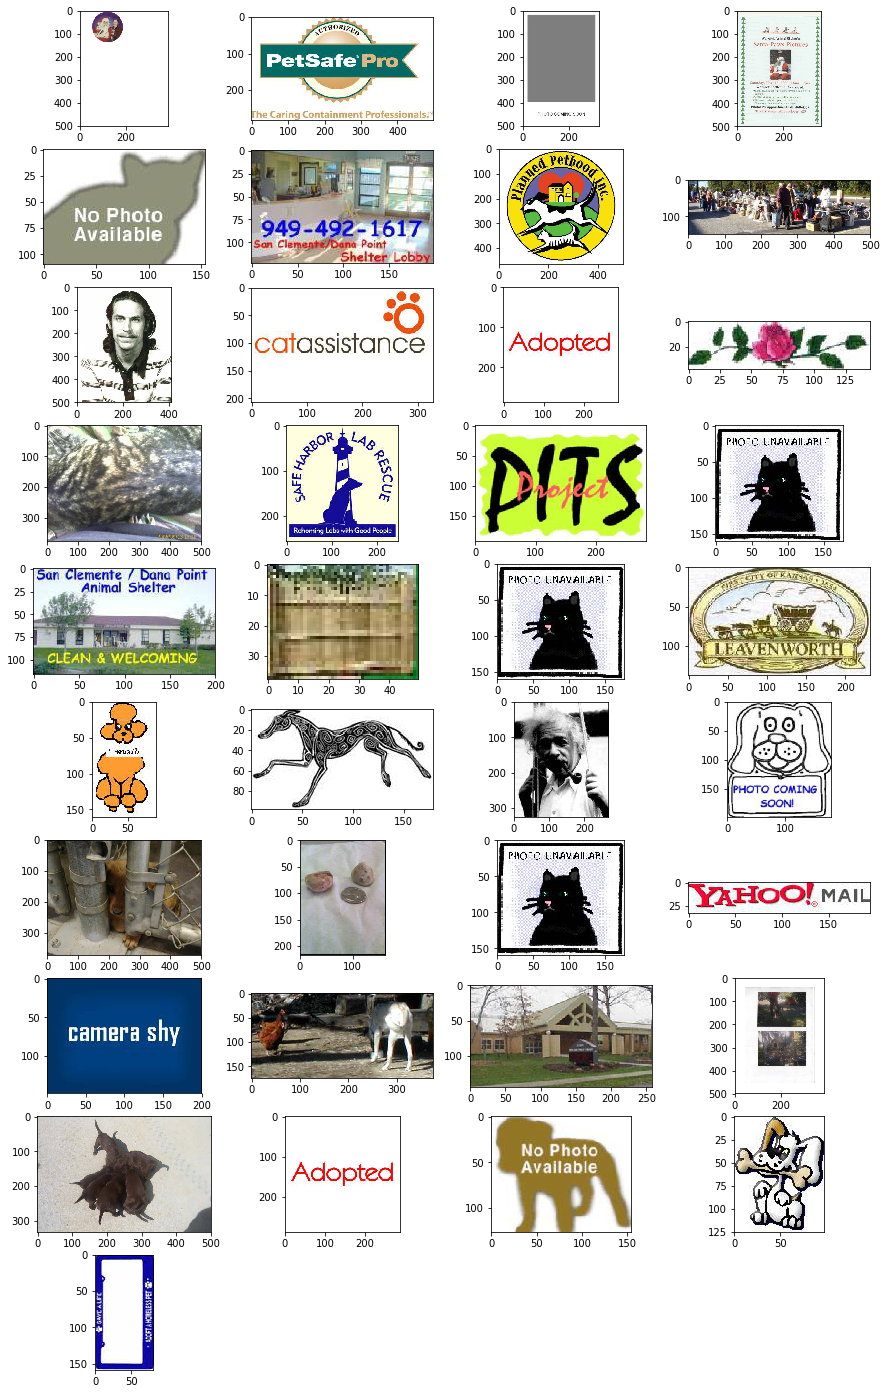

In [13]:
remove_files = []
fig = plt.figure(figsize=(15,25))
for i,no in enumerate(remove_list):
    path = 'data/train_src/' + test_gen.filenames[indices[no]]
    remove_files.append(path)
    sub_img = fig.add_subplot(10,4,1+i)
    sub_img.imshow(plt.imread(path))
plt.show()

In [16]:
remove_files = set(remove_files)

#### 数据清洗并按要求归档

In [17]:
from glob2 import glob

cats = []
dogs = []

for path in glob('data/train_src/*/*.jpg'):
    if path not in remove_files and 'cat' in path: 
        cats.append(path)
    elif path not in remove_files and 'dog' in path:
        dogs.append(path)

In [20]:
import os
import shutil

def move_file(src_files, target_path):
    for src_file in src_files:
        _,filename = os.path.split(src_file)
        target_file = target_path + filename
        shutil.copyfile(src_file, target_file)

move_file(cats, './data/train/cat/')
move_file(dogs, './data/train/dog/')

# 验证文件复制
assert len(glob('./data/train/dog/*'))==len(dogs)
assert len(glob('./data/train/cat/*'))==len(cats)          

#### 猫狗图像再检查

In [21]:
datagen = image.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

retest_gen = datagen.flow_from_directory(
    'data/train',
    batch_size = 64,
    shuffle = False,
    target_size = (224,224),
    class_mode = None
)

retest_gen.next()


Found 24963 images belonging to 2 classes.


array([[[[ -16.939003 ,   47.221    ,   79.32     ],
         [ -13.939003 ,   50.221    ,   82.32     ],
         [ -10.939003 ,   53.221    ,   85.32     ],
         ...,
         [  15.060997 ,   86.221    ,  121.32     ],
         [  19.060997 ,   85.221    ,  117.32     ],
         [  17.060997 ,   83.221    ,  115.32     ]],

        [[ -16.939003 ,   47.221    ,   79.32     ],
         [ -13.939003 ,   50.221    ,   82.32     ],
         [ -10.939003 ,   53.221    ,   85.32     ],
         ...,
         [  16.060997 ,   88.221    ,  121.32     ],
         [  20.060997 ,   86.221    ,  118.32     ],
         [  18.060997 ,   84.221    ,  116.32     ]],

        [[ -16.939003 ,   47.221    ,   79.32     ],
         [ -13.939003 ,   50.221    ,   82.32     ],
         [ -10.939003 ,   53.221    ,   85.32     ],
         ...,
         [  18.060997 ,   87.221    ,  121.32     ],
         [  21.060997 ,   87.221    ,  119.32     ],
         [  19.060997 ,   85.221    ,  117.32     ]],

In [23]:
retest_gen.filenames[-1]

'dog/dog.9999.jpg'

## 模型构建

## 